# Importing libraries

In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from pandas import concat
import numpy as np
from math import sqrt
import itertools

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox

import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from matplotlib import colors
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Loading Data

In [59]:
col_names = ["date", "value"]
df = pd.read_csv("Electric_Production.csv",
                 names = col_names, header = 0, parse_dates = [0])
df['date'] = pd.to_datetime(df['date'],infer_datetime_format=True)
df = df.set_index(['date'])
df.head(10)

,value
date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151
1985-06-01,58.0904
1985-07-01,62.6202
1985-08-01,63.2485
1985-09-01,60.5846


In [3]:
df.shape

(397, 1)

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


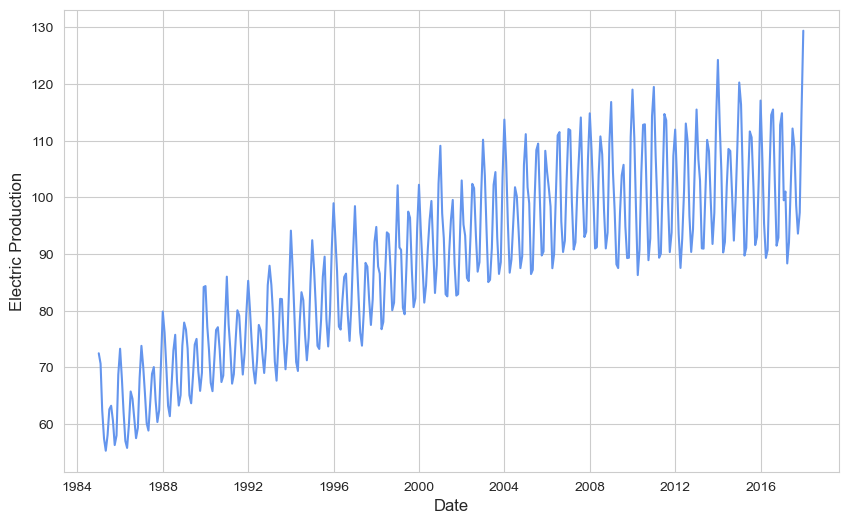

In [63]:
plt.figure(figsize = (10,6))
plt.plot(df['value'], color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.show()

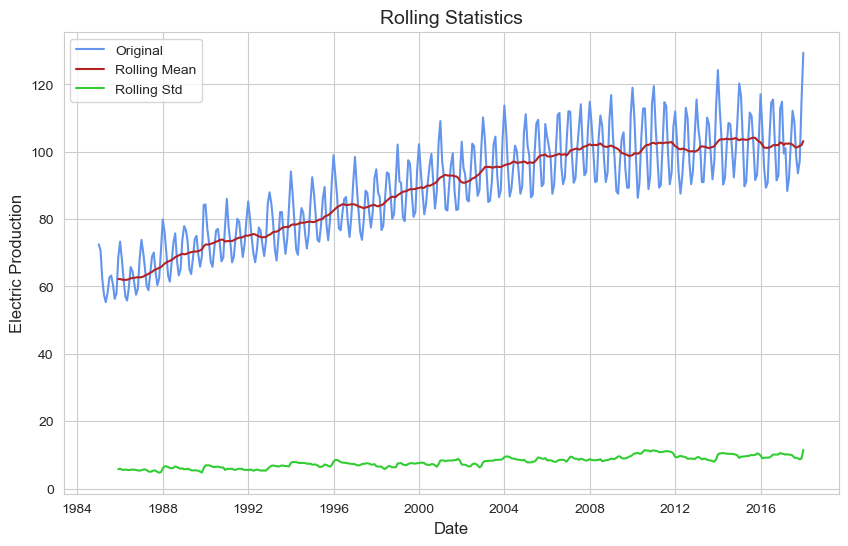

In [64]:
rolling_mean = df.rolling(window=12).mean()
rolling_std = df.rolling(window=12).std()
plt.figure(figsize = (10,6))
plt.plot(df, color='cornflowerblue', label='Original')
plt.plot(rolling_mean, color='firebrick', label='Rolling Mean')
plt.plot(rolling_std, color='limegreen', label='Rolling Std')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size  = 12)
plt.legend(loc = 'upper left')
plt.title('Rolling Statistics', size = 14)
plt.show()

# Train Test Split

In [4]:
# Convert the DataFrame column to a pandas Series
time_series = df['value']  # Replace 'Your_Column_Name' with the actual column name

# Convert the entire DataFrame to a pandas Series
df1 = df['value'].values  # Replace 'Your_Column_Name' with the actual column name

# Split indices for train and test sets
train_indices = slice(0, len(df1) - 10)
test_indices = slice(len(df1) - 10, None)

# Create train and test DataFrames
train = pd.DataFrame({'value': df1[train_indices]}, index=df.index[train_indices])
test = pd.DataFrame({'value': df1[test_indices]}, index=df.index[test_indices])

# Print the shapes of train and test DataFrames
print("Train Shape:", train.shape)
print("Test Shape:", test.shape)

Train Shape: (387, 1)
Test Shape: (10, 1)


In [5]:
train

,value
date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151
...,...
2016-11-01,92.8900
2016-12-01,112.7694
2017-01-01,114.8505


In [6]:
test

,value
date,
2017-04-01,88.3530
2017-05-01,92.0805
2017-06-01,102.1532
2017-07-01,112.1538
2017-08-01,108.9312
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359
2017-12-01,114.7212


# Plotting and Rolling Statistics

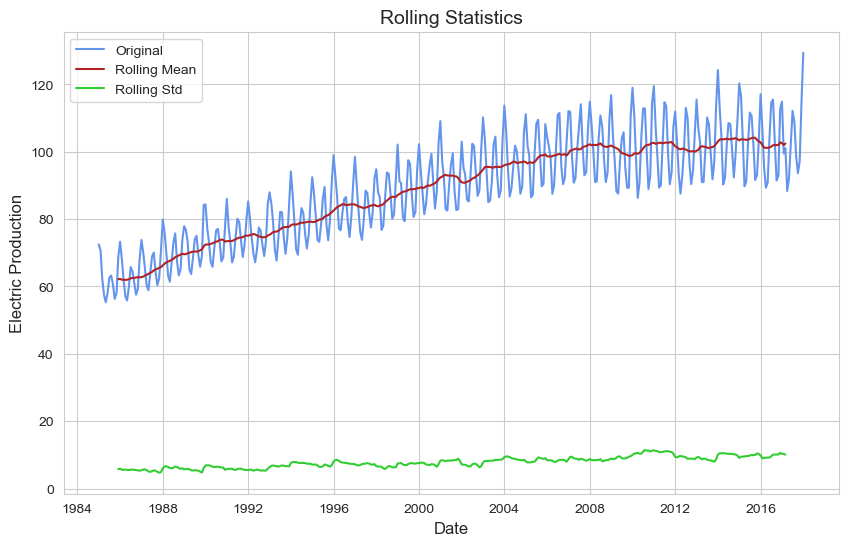

In [7]:
rolling_mean = train.rolling(window=12).mean()
rolling_std = train.rolling(window=12).std()
plt.figure(figsize = (10,6))
plt.plot(df, color='cornflowerblue', label='Original')
plt.plot(rolling_mean, color='firebrick', label='Rolling Mean')
plt.plot(rolling_std, color='limegreen', label='Rolling Std')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size  = 12)
plt.legend(loc = 'upper left')
plt.title('Rolling Statistics', size = 14)
plt.show()

# Examining Stationarity of the series

## 1- Graphical Way

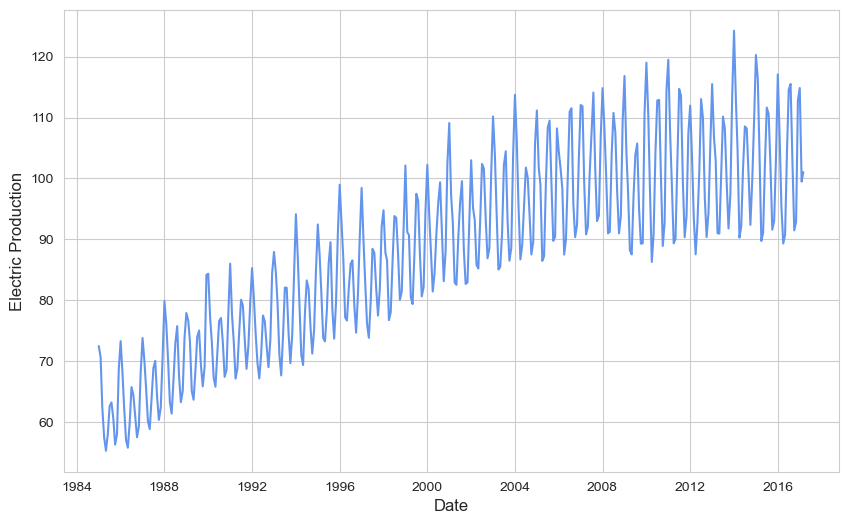

In [8]:
plt.figure(figsize = (10,6))
plt.plot(train['value'], color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.show()

Looking at the plot we can observe there is an upward trend over the period of time.

## 2- Formal Test for Stationarity

a- Augmented Dickey Fuller Test

In [9]:
def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    
    # Define null and alternative hypotheses
    print('\nNull Hypothesis: The time series has a unit root (non-stationary)')
    print('Alternative Hypothesis: The time series does not have a unit root (stationary)\n')
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

    
    # Compare the p-value to the significance level (commonly 0.05)
    p_value = dfoutput['p-value']
    alpha = 0.05
    if p_value <= alpha:
        print('\nReject the null hypothesis. The time series does not have a unit root (stationary).')
    else:
        print('\nFail to reject the null hypothesis. The time series has a unit root (non-stationary).')

# Call the function and run the test
d = 0

if d == 0:
    adf_test(train['value'])
else:
    adf_test(train['value'].diff(periods=d).dropna())

Results of Dickey-Fuller Test:

Null Hypothesis: The time series has a unit root (non-stationary)
Alternative Hypothesis: The time series does not have a unit root (stationary)

Test Statistic                  -2.468423
p-value                          0.123348
#Lags Used                      15.000000
Number of Observations Used    371.000000
Critical Value (1%)             -3.448100
Critical Value (5%)             -2.869362
Critical Value (10%)            -2.570937
dtype: float64

Fail to reject the null hypothesis. The time series has a unit root (non-stationary).


Testing stationarity for differnced series (d=1)

In [10]:
d = 1
adf_test(train['value'].diff(periods=d).dropna())

Results of Dickey-Fuller Test:

Null Hypothesis: The time series has a unit root (non-stationary)
Alternative Hypothesis: The time series does not have a unit root (stationary)

Test Statistic                -7.042039e+00
p-value                        5.813140e-10
#Lags Used                     1.400000e+01
Number of Observations Used    3.710000e+02
Critical Value (1%)           -3.448100e+00
Critical Value (5%)           -2.869362e+00
Critical Value (10%)          -2.570937e+00
dtype: float64

Reject the null hypothesis. The time series does not have a unit root (stationary).


**Conclusion:** For d = 1, we have a stationary series at 5% l.o.s. acc. to ADF test. (Inspite of non stationarity in terms of variance as seen in earlier plot)

b- Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

In [11]:
def kpss_test(timeseries):
    print('Results of KPSS Test:')
    
    # Define null and alternative hypotheses
    print('\nNull Hypothesis: The time series is stationary.')
    print('Alternative Hypothesis: The time series has a unit root (non-stationary)\n')
    
    kpss_test = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpss_test[0:3], index=['Test Statistic', 'p-value', 'Lags Used'])
    for key, value in kpss_test[3].items():
        kpss_output['Critical Value (%s)' % key] = value
    print(kpss_output)

    # Compare the p-value to the significance level (commonly 0.05)
    p_value = kpss_output['p-value']
    alpha = 0.05
    if p_value <= alpha:
        print('\nReject the null hypothesis. The time series has a unit root (non-stationary).')
    else:
        print('\nFail to reject the null hypothesis. The time series is stationary.')

# Call the function and run the test
d = 0

if d == 0:
    kpss_test(train['value'])
else:
    kpss_test(train['value'].diff(periods=d).dropna())

Results of KPSS Test:

Null Hypothesis: The time series is stationary.
Alternative Hypothesis: The time series has a unit root (non-stationary)

Test Statistic            3.447971
p-value                   0.010000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Reject the null hypothesis. The time series has a unit root (non-stationary).


In [12]:
kpss_test(train['value'].diff().dropna())

Results of KPSS Test:

Null Hypothesis: The time series is stationary.
Alternative Hypothesis: The time series has a unit root (non-stationary)

Test Statistic            0.04657
p-value                   0.10000
Lags Used                33.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64

Fail to reject the null hypothesis. The time series is stationary.


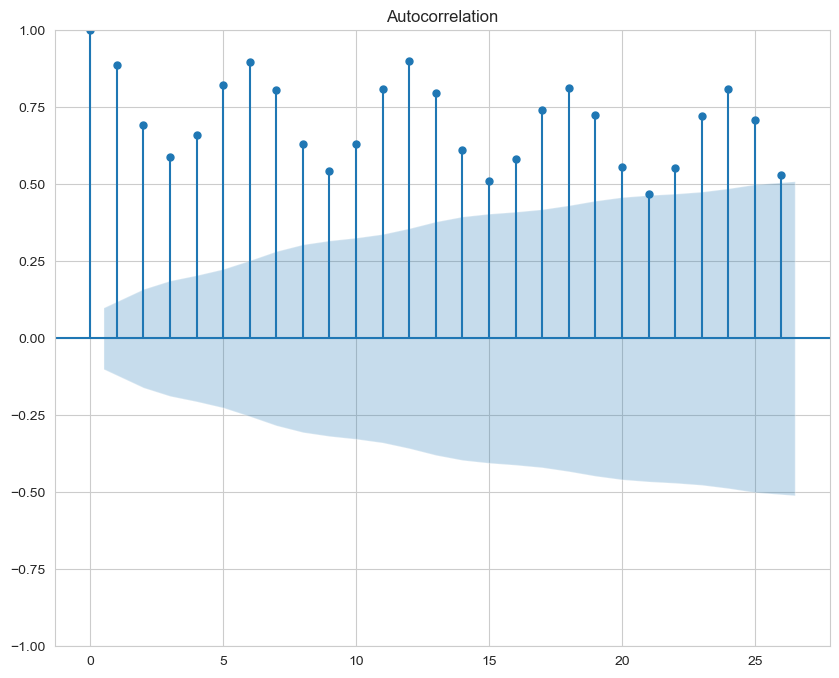

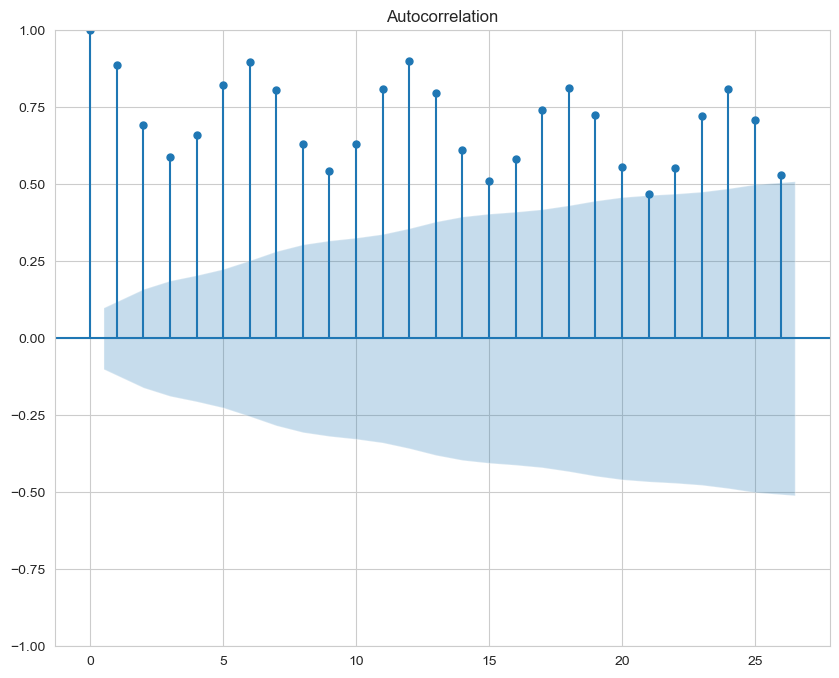

In [65]:
plot_acf(train['value'])

# Converting data to Stationary

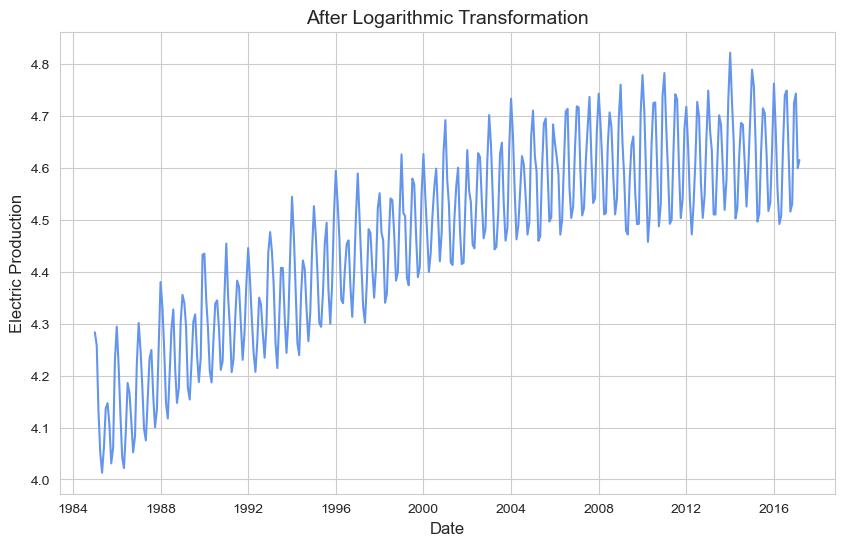

In [13]:
df_log_scaled = train
df_log_scaled['value'] = boxcox(df_log_scaled['value'], lmbda=0.0)
plt.figure(figsize = (10,6))
plt.plot(df_log_scaled, color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.title("After Logarithmic Transformation", size = 14)
plt.show()

Plotting rolling statistics alongwith the log transformed data

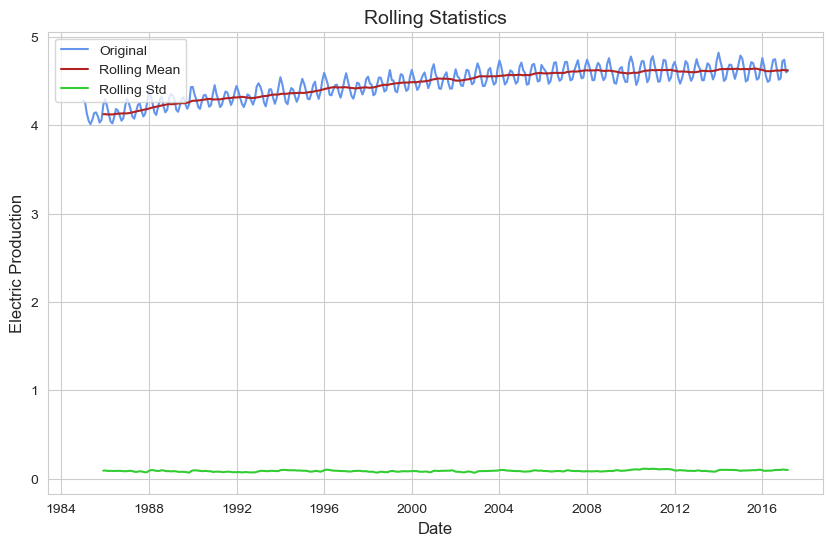

In [14]:
rolling_mean = df_log_scaled.rolling(window=12).mean()
rolling_std = df_log_scaled.rolling(window=12).std()
plt.figure(figsize = (10,6))
plt.plot(df_log_scaled, color='cornflowerblue', label='Original')
plt.plot(rolling_mean, color='firebrick', label='Rolling Mean')
plt.plot(rolling_std, color='limegreen', label='Rolling Std')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size  = 12)
plt.legend(loc = 'upper left')
plt.title('Rolling Statistics', size = 14)
plt.show()

Clearly, the given series has upward trend and we may need to difference the series to get it mean stationary.

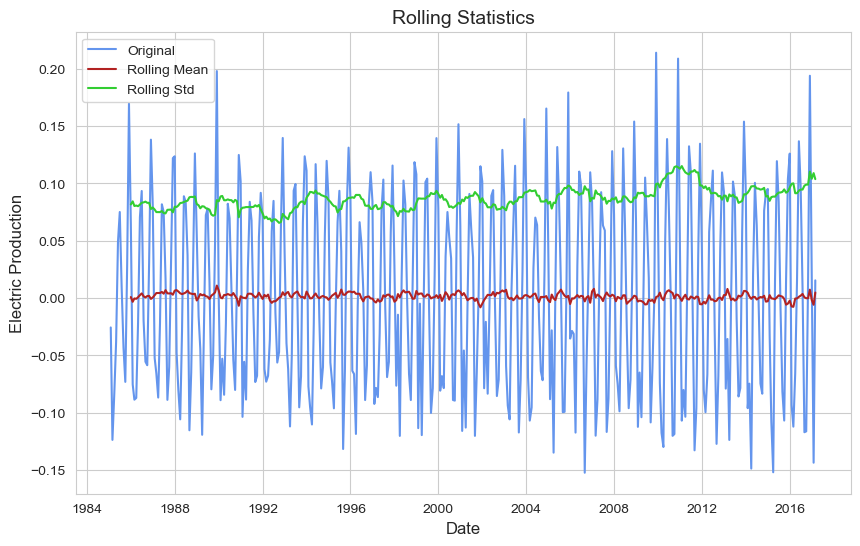

In [15]:
stat_series = df_log_scaled.diff().dropna()
rolling_mean = df_log_scaled.diff().dropna().rolling(window=12).mean()
rolling_std = df_log_scaled.diff().dropna().rolling(window=12).std()
plt.figure(figsize = (10,6))
plt.plot(df_log_scaled.diff().dropna(), color='cornflowerblue', label='Original')
plt.plot(rolling_mean, color='firebrick', label='Rolling Mean')
plt.plot(rolling_std, color='limegreen', label='Rolling Std')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size  = 12)
plt.legend(loc = 'upper left')
plt.title('Rolling Statistics', size = 14)
plt.show()

Checking stationaroty for this series

In [16]:
adf_test(df_log_scaled.diff().dropna())

Results of Dickey-Fuller Test:

Null Hypothesis: The time series has a unit root (non-stationary)
Alternative Hypothesis: The time series does not have a unit root (stationary)

Test Statistic                -6.630798e+00
p-value                        5.721816e-09
#Lags Used                     1.400000e+01
Number of Observations Used    3.710000e+02
Critical Value (1%)           -3.448100e+00
Critical Value (5%)           -2.869362e+00
Critical Value (10%)          -2.570937e+00
dtype: float64

Reject the null hypothesis. The time series does not have a unit root (stationary).


# Decomposition

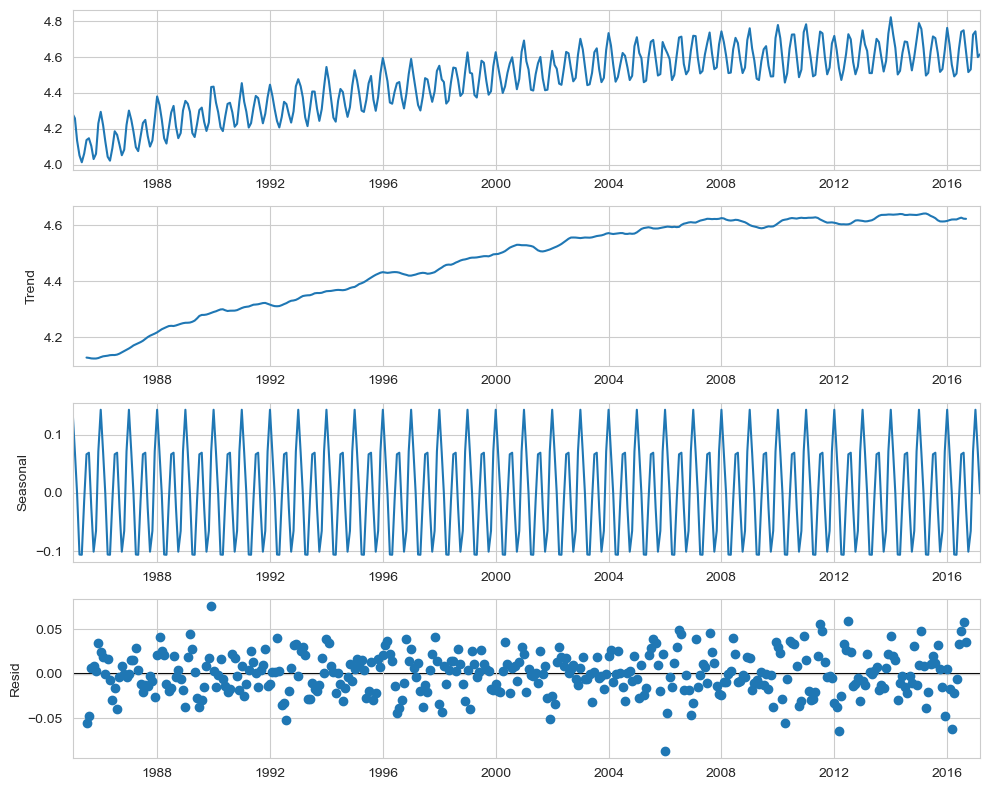

In [66]:
rcParams['figure.figsize']=10,8
df_seasonal_decompose = seasonal_decompose(df_log_scaled, 
                                           model='additive')
df_seasonal_decompose.plot()
plt.show()

# Removing Trend Non Stationarity

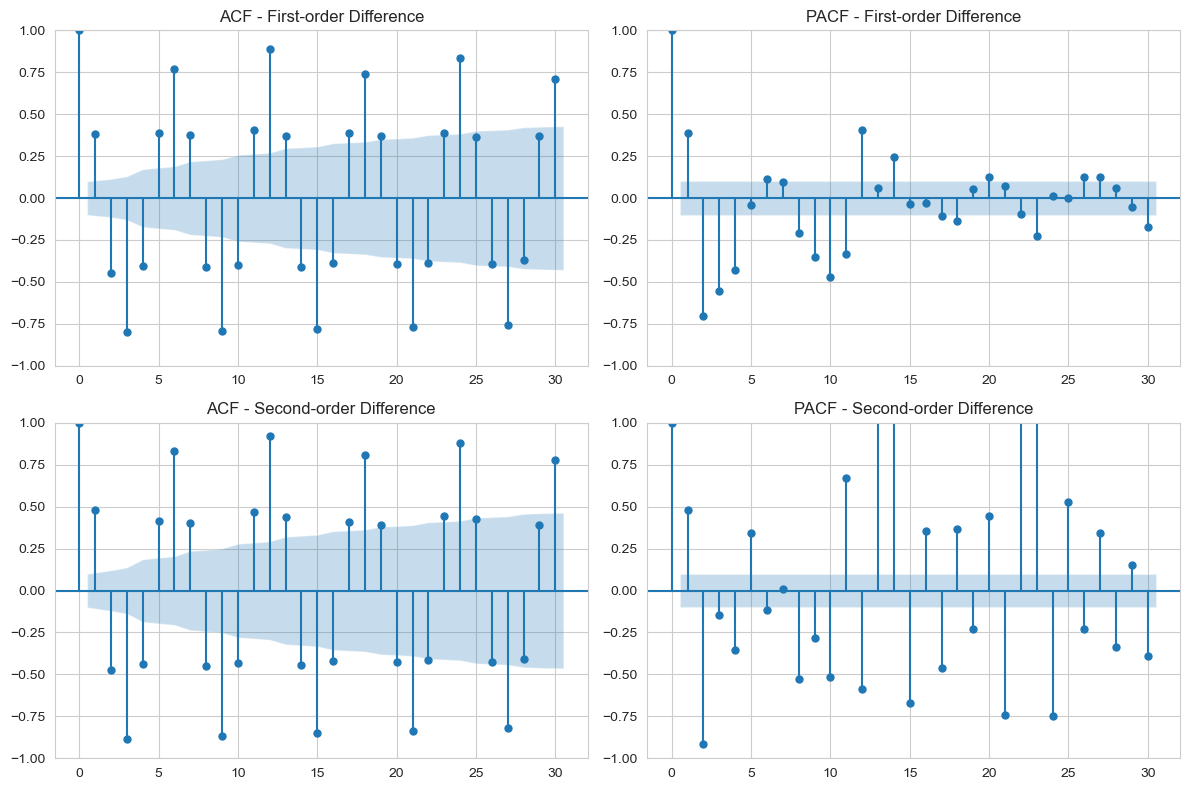

In [18]:
# Calculate first and second order differences
time_series_diff_1 = df_log_scaled.diff(periods=1).dropna()
time_series_diff_2 = df_log_scaled.diff(periods=2).dropna()

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot ACF for first-order difference
plot_acf(time_series_diff_1, lags=30, ax=axes[0, 0])
axes[0, 0].set_title('ACF - First-order Difference')

# Plot PACF for first-order difference
plot_pacf(time_series_diff_1, lags=30, ax=axes[0, 1])
axes[0, 1].set_title('PACF - First-order Difference')

# Plot ACF for second-order difference
plot_acf(time_series_diff_2, lags=30, ax=axes[1, 0])
axes[1, 0].set_title('ACF - Second-order Difference')

# Plot PACF for second-order difference
plot_pacf(time_series_diff_2, lags=30, ax=axes[1, 1])
axes[1, 1].set_title('PACF - Second-order Difference')

# Adjust layout
plt.tight_layout()
plt.show()

Clearly at d=2, we are overdifferencing. So, we will choose d=1. But as clear from the ACF plots, we have seasonality here. So, we will use SARIMA.

# ARIMA MODELS

In [19]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

time_series = df_log_scaled

# Define the range of p, d, q values for ARIMA models
p_values = range(1, 14)  # AR order
q_values = range(1, 10)  # MA order

# Initialize empty lists to store model orders, AIC, BIC, and RMSE values
model_orders = []
aics = []
bics = []
rmses = []

# Iterate over all combinations of p, d, q values
for p in p_values:
    for q in q_values:
        try:
            # Fit ARIMA(p, 1, q) model
            model = ARIMA(time_series, order=(p, 1, q))
            model_fit = model.fit()

            # Get model order, AIC, BIC, and RMSE values
            model_order = f"ARIMA({p}, 1, {q})"
            aic = model_fit.aic
            bic = model_fit.bic
            predictions = model_fit.predict(start=1, end=len(time_series))
            mse = mean_squared_error(time_series.values[1:], predictions[1:])
            rmse = np.sqrt(mse)

            # Append values to the lists
            model_orders.append(model_order)
            aics.append(aic)
            bics.append(bic)
            rmses.append(rmse)

            # Print model order and corresponding AIC, BIC, and RMSE values
            print(f"ARIMA({p}, 1, {q}) model: AIC={aic}, BIC={bic}, RMSE={rmse}")
        
        except Exception as e:
            print(f"Error fitting ARIMA({p}, 1, {q}) model:")
            print(e)

# Create a DataFrame to store the results
results = pd.DataFrame({'Model Order': model_orders,
                       'AIC': aics,
                       'BIC': bics,
                       'RMSE': rmses})

# Print all models and their AIC, BIC, and RMSE values
print("\nAll Models:")
print(results)

# Get the best model with the lowest AIC value
best_model_aic = results.loc[results['AIC'].idxmin()]

# Get the best model with the lowest BIC value
best_model_bic = results.loc[results['BIC'].idxmin()]

# Get the best model with the lowest RMSE value
best_model_rmse = results.loc[results['RMSE'].idxmin()]

# Print the best models
print("\nBest Model according to AIC:")
print(best_model_aic)

print("\nBest Model according to BIC:")
print(best_model_bic)

print("\nBest Model according to RMSE:")
print(best_model_rmse)

ARIMA(1, 1, 1) model: AIC=-955.3766072682596, BIC=-943.5090951598651, RMSE=0.04657773111185581
ARIMA(1, 1, 2) model: AIC=-1069.5686728320716, BIC=-1053.7453233542124, RMSE=0.04013015224632534
ARIMA(1, 1, 3) model: AIC=-1114.7252964001605, BIC=-1094.9461095528363, RMSE=0.04425452275288633
ARIMA(1, 1, 4) model: AIC=-1129.832033619634, BIC=-1106.097009402845, RMSE=0.04617653925857304
ARIMA(1, 1, 5) model: AIC=-1216.0209458732309, BIC=-1188.3300842869771, RMSE=0.05734770558053312
ARIMA(1, 1, 6) model: AIC=-1247.123206683255, BIC=-1215.4765077275363, RMSE=0.05926562140756037
ARIMA(1, 1, 7) model: AIC=-1269.6419053425568, BIC=-1234.0393690173732, RMSE=0.0633866396232252
ARIMA(1, 1, 8) model: AIC=-1275.4302597085357, BIC=-1235.8718860138874, RMSE=0.06432332707519796
ARIMA(1, 1, 9) model: AIC=-1129.3142206499913, BIC=-1085.8000095858781, RMSE=0.057504953228630924
ARIMA(2, 1, 1) model: AIC=-1322.3553869288744, BIC=-1306.5320374510152, RMSE=0.0718578843340795
ARIMA(2, 1, 2) model: AIC=-1439.7868

ARIMA(10, 1, 5) model: AIC=-1575.8352895698026, BIC=-1512.5418916583653, RMSE=0.07652669525417855
ARIMA(10, 1, 6) model: AIC=-1594.76064653208, BIC=-1527.5114112511778, RMSE=0.07693606002579902
ARIMA(10, 1, 7) model: AIC=-1597.2015272221226, BIC=-1525.9964545717557, RMSE=0.07709735834217384
ARIMA(10, 1, 8) model: AIC=-1630.823660490039, BIC=-1555.6627504702071, RMSE=0.07678640022644934
ARIMA(10, 1, 9) model: AIC=-1615.2531168145265, BIC=-1536.13636942523, RMSE=0.07703294183263666
ARIMA(11, 1, 1) model: AIC=-1570.9082068920561, BIC=-1519.4823210890133, RMSE=0.07984537805009834
ARIMA(11, 1, 2) model: AIC=-1534.3126733377276, BIC=-1478.9309501652199, RMSE=0.07661904593499957
ARIMA(11, 1, 3) model: AIC=-1611.053984002473, BIC=-1551.7164234605007, RMSE=0.07838519425792397
ARIMA(11, 1, 4) model: AIC=-1618.9809288585561, BIC=-1555.6875309471188, RMSE=0.07745088523835146
ARIMA(11, 1, 5) model: AIC=-1619.7159444254164, BIC=-1552.4667091445142, RMSE=0.07771174540567521
ARIMA(11, 1, 6) model: AIC

## ARIMA(11,1,9)

In [71]:
arima1 = ARIMA(train, order = (11, 1, 9)).fit()

predictions = np.exp( arima1.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False) )
arima_score = np.sqrt( mean_squared_error(test, predictions) )
print('ARIMA RMSE: {}'.format(round(arima_score,4)))

ARIMA RMSE: 6.298


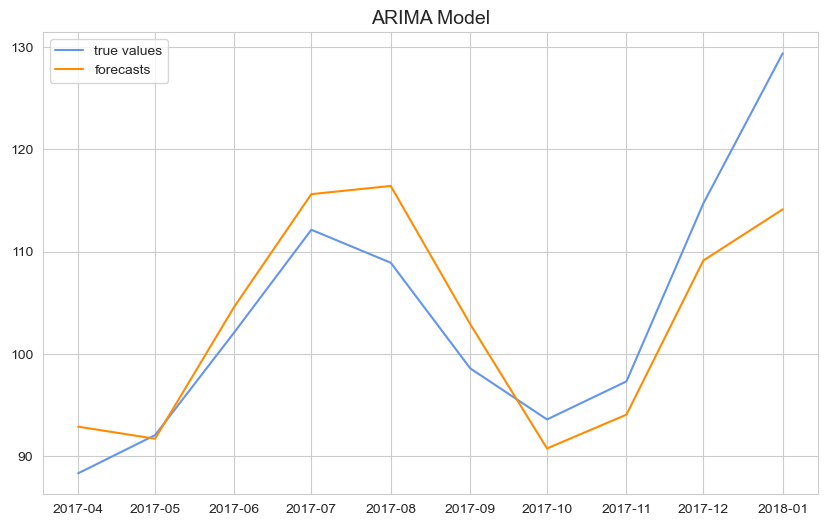

In [21]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("ARIMA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

In [68]:
arima1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  387
Model:                ARIMA(11, 1, 9)   Log Likelihood                 846.837
Date:                Wed, 16 Aug 2023   AIC                          -1651.674
Time:                        15:45:01   BIC                          -1568.601
Sample:                    01-01-1985   HQIC                         -1618.730
                         - 03-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8962      0.064    -13.994      0.000      -1.022      -0.771
ar.L2         -0.8200      0.076    -10.835      0.000      -0.968      -0.672
ar.L3         -0.9559      0.059    -16.155      0.000      -1.072      -0.840
ar.L4         -0.9202      0.087    -10.524      0.000      -1.092      -0.749
ar.L5         -0.8783      0.100     -8.811      0.000      -1.074      -0.683
ar.L6         -0.9471      0.082    -11.571      0.000      -1.108      -0.787
ar.L7         -0.7325      0.084     -8.698      0.000      -0.898      -0.567
ar.L8         -0.7614      0.085     -8.933      0.000      -0.928      -0.594
ar.L9         -0.9437      0.067    -14.151      0.000      -1.074      -0.813
ar.L10        -0.7559      0.055    -13.632      0.000      -0.865      -0.647
ar.L11        -0.6520      0.048    -13.497      0.000      -0.747      -0.557
ma.L1          0.5828      0.087      6.702      0.000       0.412       0.753
ma.L2          0.1462      0.088      1.655      0.098      -0.027       0.319
ma.L3          0.4382      0.084      5.211      0.000       0.273       0.603
ma.L4          0.3572      0.099      3.617      0.000       0.164       0.551
ma.L5          0.0808      0.098      0.828      0.408      -0.111       0.272
ma.L6          0.1423      0.091      1.559      0.119      -0.037       0.321
ma.L7         -0.1425      0.081     -1.756      0.079      -0.301       0.017
ma.L8         -0.0245      0.087     -0.282      0.778      -0.195       0.146
ma.L9          0.3347      0.084      4.003      0.000       0.171       0.499
sigma2         0.0007   4.87e-05     14.399      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                 9.18
Prob(Q):                              0.64   Prob(JB):                         0.01
Heteroskedasticity (H):               1.30   Skew:                             0.24
Prob(H) (two-sided):                  0.14   Kurtosis:                         3.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## ARIMA(12,1,2)

In [72]:
arima2 = ARIMA(train, order = (12, 1, 2)).fit()

predictions = np.exp(arima2.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False))
arima_score = np.sqrt( mean_squared_error(test, predictions) )
print('ARIMA RMSE: {}'.format(round(arima_score,4)))

ARIMA RMSE: 6.1313


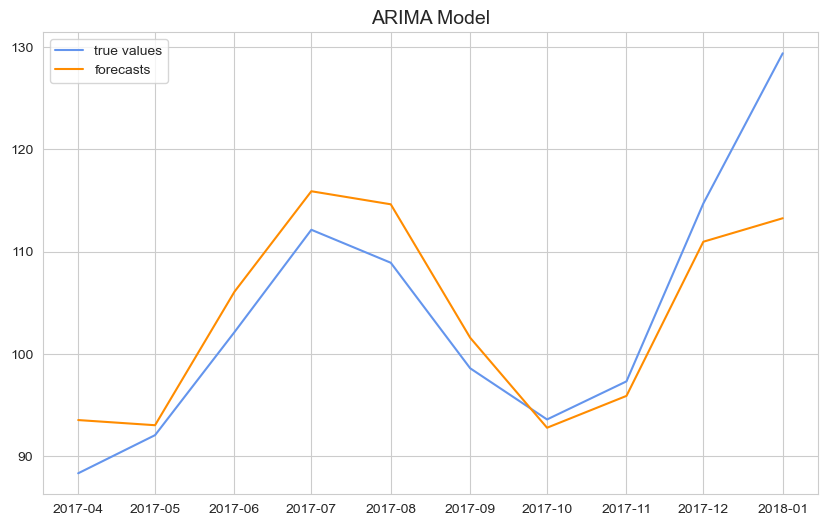

In [24]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("ARIMA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

In [25]:
arima2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  387
Model:                ARIMA(12, 1, 2)   Log Likelihood                 831.734
Date:                Tue, 15 Aug 2023   AIC                          -1633.469
Time:                        19:08:45   BIC                          -1574.131
Sample:                    01-01-1985   HQIC                         -1609.937
                         - 03-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0656      0.061     -1.071      0.284      -0.186       0.054
ar.L2          0.0123      0.067      0.183      0.855      -0.119       0.144
ar.L3         -0.0922      0.054     -1.719      0.086      -0.197       0.013
ar.L4         -0.0870      0.060     -1.461      0.144      -0.204       0.030
ar.L5         -0.0451      0.060     -0.757      0.449      -0.162       0.072
ar.L6          0.0080      0.057      0.140      0.889      -0.104       0.120
ar.L7          0.0138      0.057      0.241      0.809      -0.098       0.126
ar.L8         -0.0528      0.054     -0.986      0.324      -0.158       0.052
ar.L9         -0.1117      0.051     -2.182      0.029      -0.212      -0.011
ar.L10        -0.0364      0.049     -0.741      0.458      -0.133       0.060
ar.L11         0.0897      0.054      1.664      0.096      -0.016       0.195
ar.L12         0.6750      0.040     16.807      0.000       0.596       0.754
ma.L1         -0.2285      0.078     -2.924      0.003      -0.382      -0.075
ma.L2         -0.4475      0.077     -5.782      0.000      -0.599      -0.296
sigma2         0.0008   4.97e-05     15.523      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                12.05
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                             0.25
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## ARIMA(1,1,2)

In [73]:
arima3 = ARIMA(train, order = (1, 1, 2)).fit()

predictions = np.exp( arima3.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False) )
arima_score = np.sqrt( mean_squared_error(test, predictions) )
print('ARIMA RMSE: {}'.format(round(arima_score,4)))

ARIMA RMSE: 12.2999


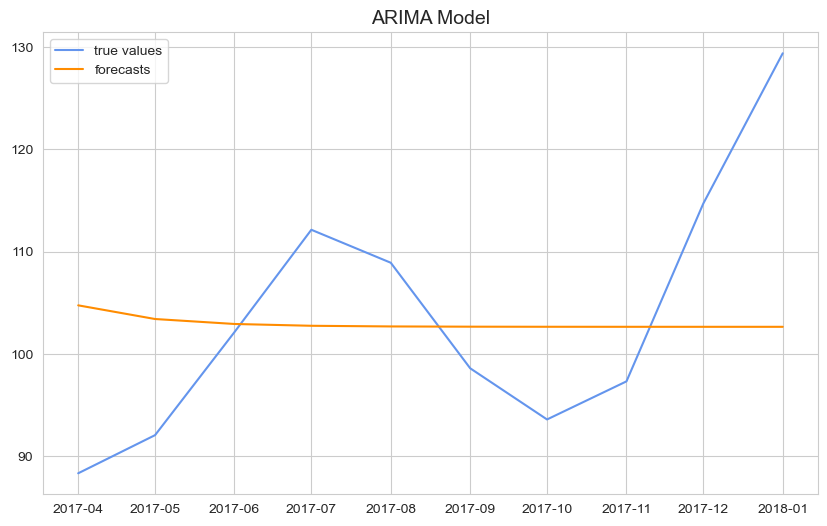

In [27]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("ARIMA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

In [28]:
arima3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  387
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 538.784
Date:                Tue, 15 Aug 2023   AIC                          -1069.569
Time:                        19:08:46   BIC                          -1053.745
Sample:                    01-01-1985   HQIC                         -1063.294
                         - 03-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3657      0.078      4.688      0.000       0.213       0.519
ma.L1         -0.2396      0.053     -4.541      0.000      -0.343      -0.136
ma.L2         -0.6624      0.048    -13.839      0.000      -0.756      -0.569
sigma2         0.0036      0.000     12.750      0.000       0.003       0.004
===================================================================================
Ljung-Box (L1) (Q):                   6.37   Jarque-Bera (JB):                 1.24
Prob(Q):                              0.01   Prob(JB):                         0.54
Heteroskedasticity (H):               1.36   Skew:                            -0.01
Prob(H) (two-sided):                  0.08   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# SARIMA MODELS

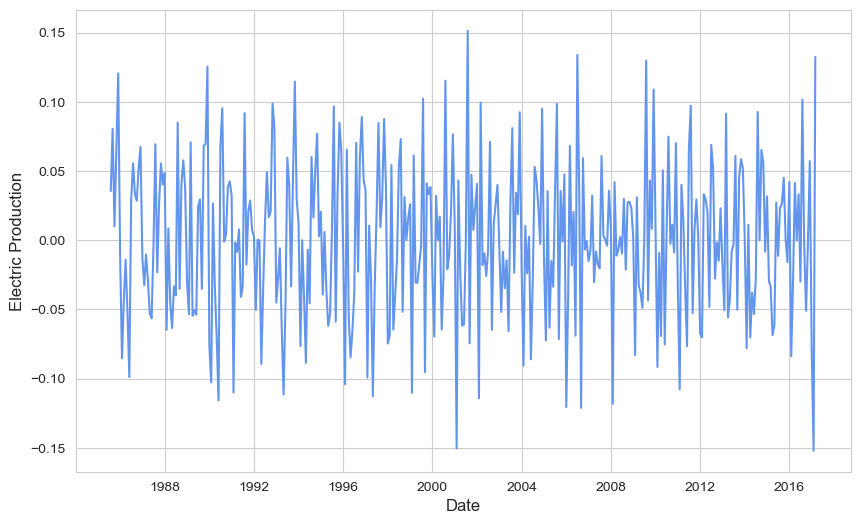

In [29]:
plt.figure(figsize = (10,6))
plt.plot(stat_series.diff(6).dropna(), color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.show()

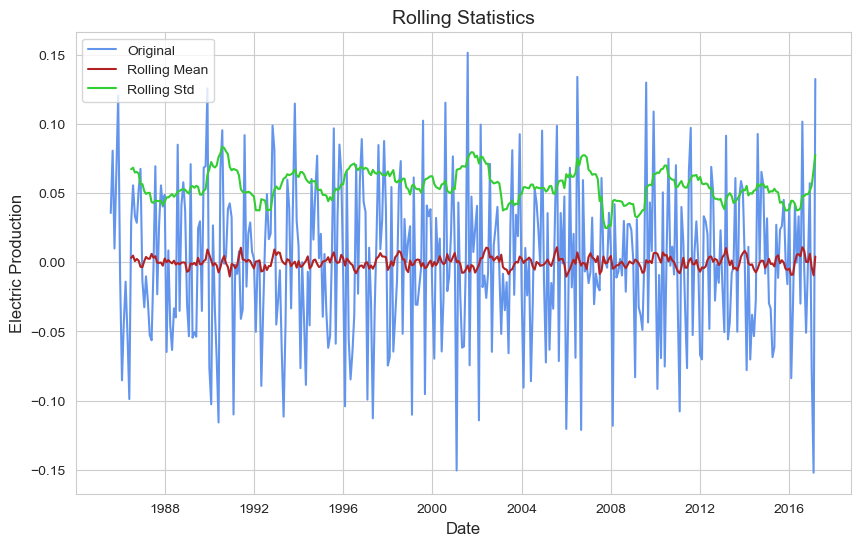

In [30]:
rolling_mean = stat_series.diff(6).dropna().rolling(window=12).mean()
rolling_std = stat_series.diff(6).dropna().rolling(window=12).std()
plt.figure(figsize = (10,6))
plt.plot(stat_series.diff(6).dropna(), color='cornflowerblue', label='Original')
plt.plot(rolling_mean, color='firebrick', label='Rolling Mean')
plt.plot(rolling_std, color='limegreen', label='Rolling Std')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size  = 12)
plt.legend(loc = 'upper left')
plt.title('Rolling Statistics', size = 14)
plt.show()

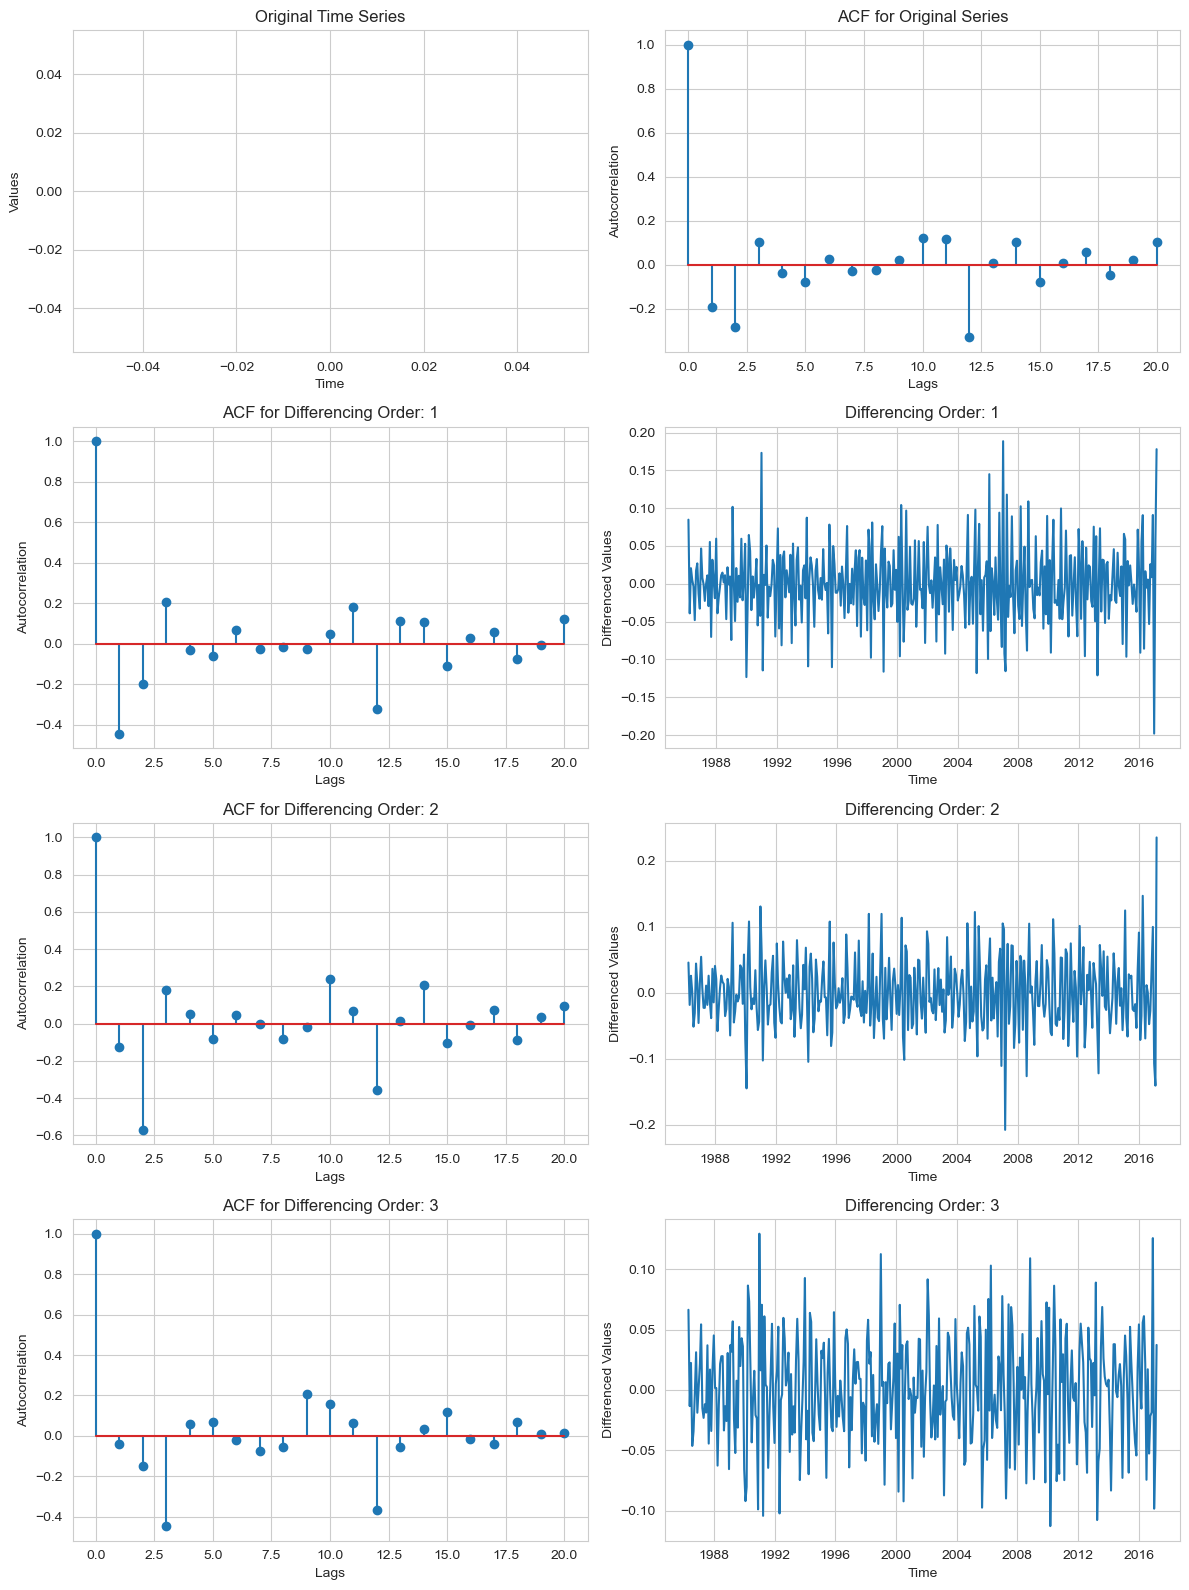

In [31]:
# Define the maximum order of differencing to consider
max_d = 3

# Create a figure with subplots
fig, axes = plt.subplots(nrows=max_d+1, ncols=2, figsize=(12, 4*(max_d+1)))

# Plot the original time series
axes[0, 0].plot()
axes[0, 0].set_title("Original Time Series")
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("Values")

# Generate plots for different orders of differencing
for d in range(0, max_d + 1):
    if d == 0:
        # Plot the ACF for the original series
        acf_values = acf(stat_series.diff(12).dropna(), nlags=20)
        axes[d, 1].stem(range(len(acf_values)), acf_values)
        axes[d, 1].set_title("ACF for Original Series")
        axes[d, 1].set_xlabel("Lags")
        axes[d, 1].set_ylabel("Autocorrelation")
    else:
        # Perform differencing
        differenced_series = stat_series.diff(12).dropna().diff(periods=d).dropna()

        # Plot the differenced series
        axes[d, 1].plot(differenced_series)
        axes[d, 1].set_title(f"Differencing Order: {d}")
        axes[d, 1].set_xlabel("Time")
        axes[d, 1].set_ylabel("Differenced Values")

        # Compute autocorrelation
        lag = 20
        acf_values = acf(differenced_series, nlags=lag)

        # Plot the ACF for the differenced series
        axes[d, 0].stem(range(len(acf_values)), acf_values)
        axes[d, 0].set_title(f"ACF for Differencing Order: {d}")
        axes[d, 0].set_xlabel("Lags")
        axes[d, 0].set_ylabel("Autocorrelation")

# Adjust the layout and spacing
plt.tight_layout()
plt.show()

## Checking Stationarity for the seasonal differenced data

ADF TEST

In [74]:
adf_test(stat_series.diff(12).dropna())

Results of Dickey-Fuller Test:

Null Hypothesis: The time series has a unit root (non-stationary)
Alternative Hypothesis: The time series does not have a unit root (stationary)

Test Statistic                -7.847326e+00
p-value                        5.722827e-12
#Lags Used                     1.500000e+01
Number of Observations Used    3.580000e+02
Critical Value (1%)           -3.448749e+00
Critical Value (5%)           -2.869647e+00
Critical Value (10%)          -2.571089e+00
dtype: float64

Reject the null hypothesis. The time series does not have a unit root (stationary).


KPSS TEST

In [75]:
kpss_test(stat_series.diff(12).dropna())

Results of KPSS Test:

Null Hypothesis: The time series is stationary.
Alternative Hypothesis: The time series has a unit root (non-stationary)

Test Statistic            0.040091
p-value                   0.100000
Lags Used                18.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Fail to reject the null hypothesis. The time series is stationary.


Clearly, we have to take D = 0 here as the series is not trend stationary as per the KPSS test.

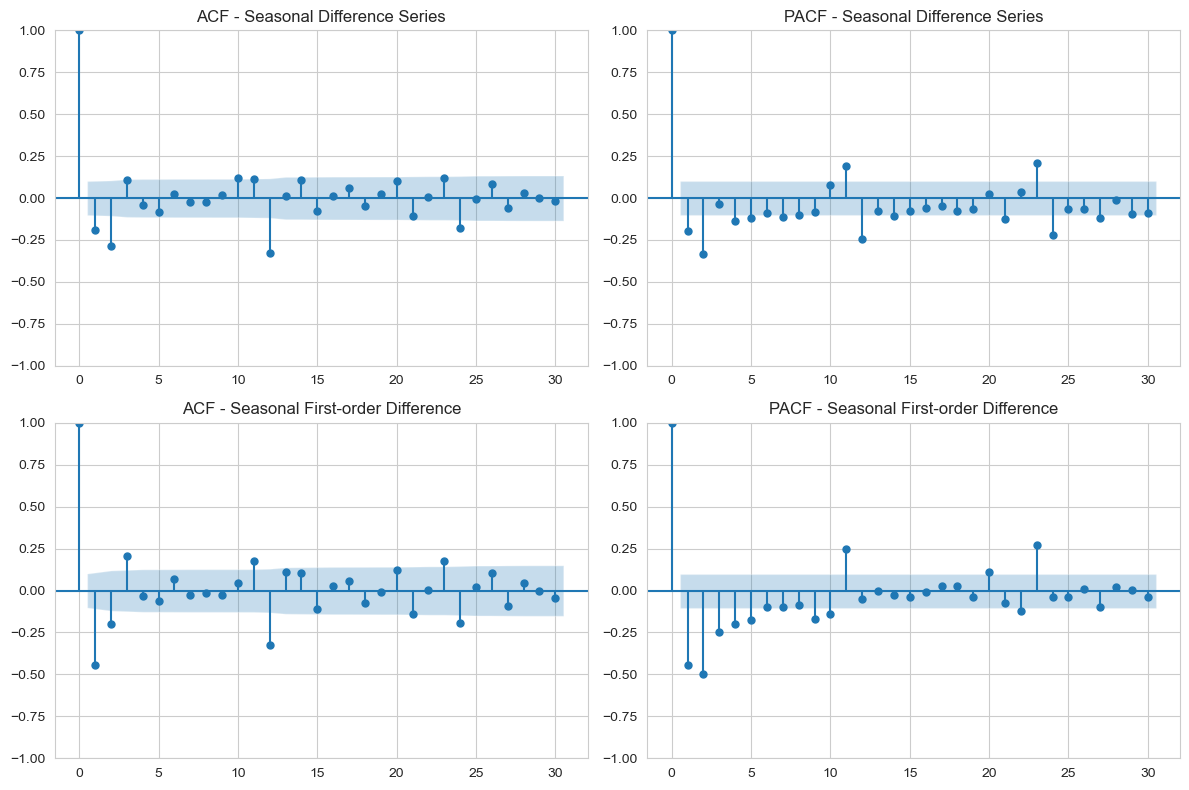

In [34]:
# Calculate first and second order differences
time_series_diff_1 = stat_series.diff(periods=12).dropna()
time_series_diff_2 = stat_series.diff(periods=12).dropna().diff(1).dropna()

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot ACF for first-order difference
plot_acf(time_series_diff_1, lags=30, ax=axes[0, 0])
axes[0, 0].set_title('ACF - Seasonal Difference Series')

# Plot PACF for first-order difference
plot_pacf(time_series_diff_1, lags=30, ax=axes[0, 1])
axes[0, 1].set_title('PACF - Seasonal Difference Series')

# Plot ACF for second-order difference
plot_acf(time_series_diff_2, lags=30, ax=axes[1, 0])
axes[1, 0].set_title('ACF - Seasonal First-order Difference')

# Plot PACF for second-order difference
plot_pacf(time_series_diff_2, lags=30, ax=axes[1, 1])
axes[1, 1].set_title('PACF - Seasonal First-order Difference')

# Adjust layout
plt.tight_layout()
plt.show()

In [35]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Load your time series data into 'df_log_scaled'
# Assuming you have a pandas DataFrame named 'df_log_scaled' and a column named 'Your_Column_Name'

# Convert the DataFrame column to a pandas Series
time_series = df_log_scaled  # Replace 'Your_Column_Name' with the actual column name

# Define the range of p, q, P, Q values for SARIMA models
p_values = range(0, 3)   # AR order
q_values = range(0, 3)   # MA order
P_values = range(0, 6)   # Seasonal AR order
Q_values = range(0, 4)   # Seasonal MA order

# Initialize empty lists to store model orders, AIC, BIC, and RMSE values
model_orders = []
aics = []
bics = []
rmses = []

# Iterate over all combinations of p, q, P, Q values
for p, q, P, Q in itertools.product(p_values, q_values, P_values, Q_values):
    try:
        # Fit SARIMA(p, 1, q)(P, 0, Q, 12) model
        model = SARIMAX(time_series, order=(p, 1, q), seasonal_order=(P, 0, Q, 12))
        model_fit = model.fit(disp=False)

        # Get model order, AIC, BIC, and RMSE values
        model_order = f"SARIMA({p}, 1, {q})({P}, 0, {Q}, 12)"
        aic = model_fit.aic
        bic = model_fit.bic
        forecast = model_fit.forecast(steps=len(time_series))
        mse = mean_squared_error(time_series[:1], forecast[:1])
        rmse = np.sqrt(mse)

        # Append values to the lists
        model_orders.append(model_order)
        aics.append(aic)
        bics.append(bic)
        rmses.append(rmse)

        # Print model order and corresponding AIC, BIC, and RMSE values
        print(f"SARIMA({p}, 1, {q})({P}, 0, {Q}, 12) model: AIC={aic}, BIC={bic}, RMSE={rmse}")
    
    except Exception as e:
        print(f"Error fitting SARIMA({p}, 1, {q})({P}, 0, {Q}, 12) model:")
        print(e)

# Create a DataFrame to store the results
results = pd.DataFrame({'Model Order': model_orders,
                       'AIC': aics,
                       'BIC': bics,
                       'RMSE': rmses})

# Print all models and their AIC, BIC, and RMSE values
print("\nAll Models:")
print(results)

# Get the best model with the lowest AIC value
best_model_aic = results.loc[results['AIC'].idxmin()]

# Get the best model with the lowest BIC value
best_model_bic = results.loc[results['BIC'].idxmin()]

# Get the best model with the lowest RMSE value
best_model_rmse = results.loc[results['RMSE'].idxmin()]

# Print the best models
print("\nBest Model according to AIC:")
print(best_model_aic)

print("\nBest Model according to BIC:")
print(best_model_bic)

print("\nBest Model according to RMSE:")
print(best_model_rmse)


SARIMA(0, 1, 0)(0, 0, 0, 12) model: AIC=-816.7788221201, BIC=-812.8229847506352, RMSE=0.33185423577970585
SARIMA(0, 1, 0)(0, 0, 1, 12) model: AIC=-1116.0803361317448, BIC=-1108.1686613928152, RMSE=0.3351414522239251
SARIMA(0, 1, 0)(0, 0, 2, 12) model: AIC=-1242.6282161875356, BIC=-1230.760704079141, RMSE=0.3166006961946186
SARIMA(0, 1, 0)(0, 0, 3, 12) model: AIC=-1317.5640525974559, BIC=-1301.7407031195967, RMSE=0.3251314892921435
SARIMA(0, 1, 0)(1, 0, 0, 12) model: AIC=-1510.3485821191416, BIC=-1502.436907380212, RMSE=0.2713097267873348
SARIMA(0, 1, 0)(1, 0, 1, 12) model: AIC=-1646.9428218563457, BIC=-1635.0753097479512, RMSE=0.22362293453771276
SARIMA(0, 1, 0)(1, 0, 2, 12) model: AIC=-1645.804786562176, BIC=-1629.981437084317, RMSE=0.23521890217939667
SARIMA(0, 1, 0)(1, 0, 3, 12) model: AIC=-1653.9344918560969, BIC=-1634.1553050087728, RMSE=0.23254807860626414
SARIMA(0, 1, 0)(2, 0, 0, 12) model: AIC=-1549.4549769288792, BIC=-1537.5874648204847, RMSE=0.240217308556133
SARIMA(0, 1, 0)(

SARIMA(1, 1, 0)(0, 0, 3, 12) model: AIC=-1317.7283745323043, BIC=-1297.9491876849802, RMSE=0.3317589599511406
SARIMA(1, 1, 0)(1, 0, 0, 12) model: AIC=-1518.6064448120717, BIC=-1506.7389327036772, RMSE=0.2503932878524653
SARIMA(1, 1, 0)(1, 0, 1, 12) model: AIC=-1660.2094350097477, BIC=-1644.3860855318885, RMSE=0.20324882816635714
SARIMA(1, 1, 0)(1, 0, 2, 12) model: AIC=-1660.7169960752917, BIC=-1640.9378092279676, RMSE=0.21056172309882193
SARIMA(1, 1, 0)(1, 0, 3, 12) model: AIC=-1637.4818894675068, BIC=-1613.7468652507177, RMSE=0.21524542965529925
SARIMA(1, 1, 0)(2, 0, 0, 12) model: AIC=-1560.554446408612, BIC=-1544.7310969307528, RMSE=0.21594798763312362
SARIMA(1, 1, 0)(2, 0, 1, 12) model: AIC=-1658.2258856916965, BIC=-1638.4466988443723, RMSE=0.20721262957376307
SARIMA(1, 1, 0)(2, 0, 2, 12) model: AIC=-1659.355773464764, BIC=-1635.620749247975, RMSE=0.205704559092573
SARIMA(1, 1, 0)(2, 0, 3, 12) model: AIC=-1656.5932278861105, BIC=-1628.9023662998568, RMSE=0.20945266326390843
SARIMA(1

SARIMA(2, 1, 0)(1, 0, 2, 12) model: AIC=-1686.93517505711, BIC=-1663.200150840321, RMSE=0.22802032442995213
SARIMA(2, 1, 0)(1, 0, 3, 12) model: AIC=-1665.4922902607732, BIC=-1637.8014286745195, RMSE=0.22934640946149187
SARIMA(2, 1, 0)(2, 0, 0, 12) model: AIC=-1599.7166839272898, BIC=-1579.9374970799656, RMSE=0.2353470363439989
SARIMA(2, 1, 0)(2, 0, 1, 12) model: AIC=-1683.3236863501556, BIC=-1659.5886621333666, RMSE=0.22444665608344394
SARIMA(2, 1, 0)(2, 0, 2, 12) model: AIC=-1686.6057506097766, BIC=-1658.9148890235228, RMSE=0.2245980514720607
SARIMA(2, 1, 0)(2, 0, 3, 12) model: AIC=-1674.5532839673056, BIC=-1642.906585011587, RMSE=0.22630308229876395
SARIMA(2, 1, 0)(3, 0, 0, 12) model: AIC=-1641.6656129074047, BIC=-1617.9305886906157, RMSE=0.22130027300134358
SARIMA(2, 1, 0)(3, 0, 1, 12) model: AIC=-1672.9848613696627, BIC=-1645.293999783409, RMSE=0.22890640648895832
SARIMA(2, 1, 0)(3, 0, 2, 12) model: AIC=-1687.3302307257502, BIC=-1655.6835317700315, RMSE=0.22221593154097086
SARIMA(2

### SARIMA(1,1,2)(3,0,2,12)

In [77]:
sarima1 = SARIMAX(train, order = (1, 1, 2), seasonal_order = (3, 0, 2, 12)).fit()

predictions = np.exp( sarima1.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False) )
sarima_score = np.sqrt( mean_squared_error(test, predictions) )
print('SARIMA RMSE: {}'.format(round(sarima_score,4)))

SARIMA RMSE: 4.1573


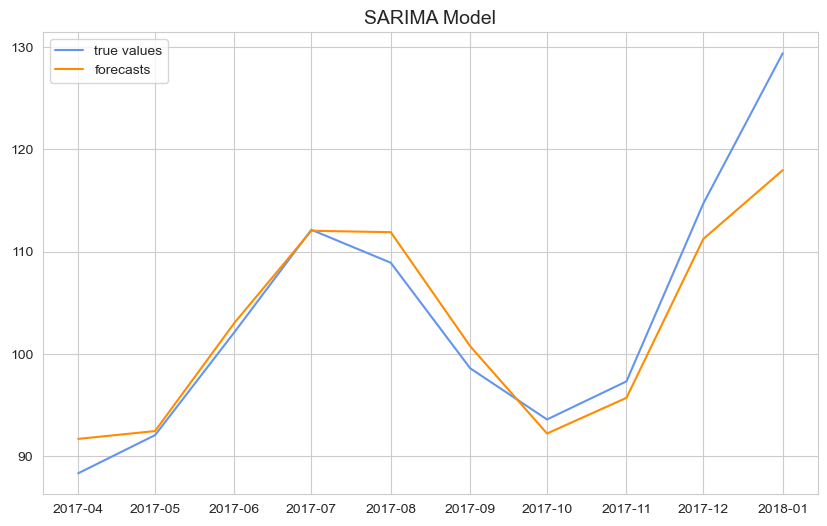

In [39]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("SARIMA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

In [40]:
sarima1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  387
Model:             SARIMAX(1, 1, 2)x(3, 0, 2, 12)   Log Likelihood                 873.242
Date:                            Tue, 15 Aug 2023   AIC                          -1728.483
Time:                                    20:20:34   BIC                          -1692.881
Sample:                                01-01-1985   HQIC                         -1714.364
                                     - 03-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3567      0.116      3.083      0.002       0.130       0.583
ma.L1         -0.7278      0.113     -6.453      0.000      -0.949      -0.507
ma.L2         -0.1698      0.088     -1.937      0.053      -0.342       0.002
ar.S.L12       0.8336      0.291      2.863      0.004       0.263       1.404
ar.S.L24       0.0192      0.323      0.060      0.953      -0.614       0.652
ar.S.L36       0.1444      0.078      1.851      0.064      -0.008       0.297
ma.S.L12      -0.5794      0.291     -1.992      0.046      -1.149      -0.009
ma.S.L24      -0.1899      0.252     -0.754      0.451      -0.684       0.304
sigma2         0.0006   3.93e-05     14.653      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 4.18
Prob(Q):                              0.89   Prob(JB):                         0.12
Heteroskedasticity (H):               1.59   Skew:                            -0.10
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### SARIMA(1,1,1)(1,0,1,12)

In [78]:
sarima2 = SARIMAX(train, order = (1, 1, 1), seasonal_order = (1, 0, 1, 12)).fit()

predictions = np.exp( sarima2.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False) )
sarima_score = np.sqrt( mean_squared_error(test, predictions) )
print('SARIMA RMSE: {}'.format(round(sarima_score,4)))

SARIMA RMSE: 4.3117


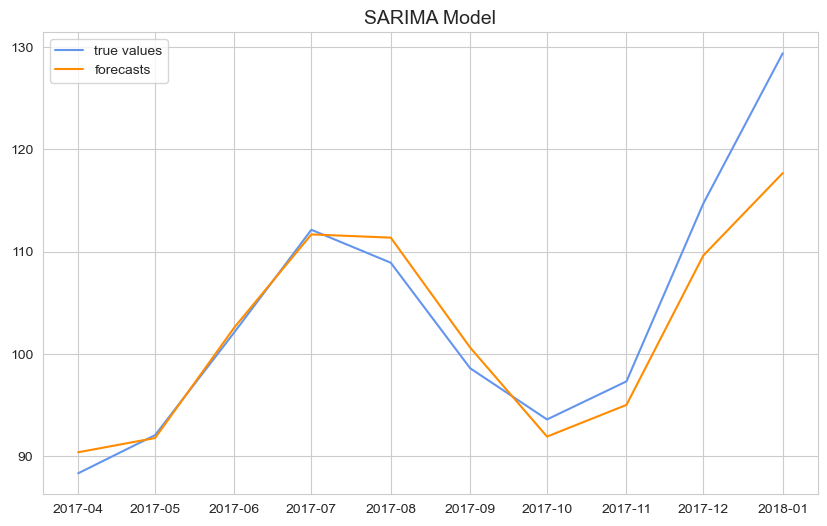

In [45]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("SARIMA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

In [46]:
sarima2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  387
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 866.393
Date:                            Tue, 15 Aug 2023   AIC                          -1722.787
Time:                                    20:23:18   BIC                          -1703.008
Sample:                                01-01-1985   HQIC                         -1714.943
                                     - 03-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5086      0.058      8.751      0.000       0.395       0.622
ma.L1         -0.9263      0.028    -33.580      0.000      -0.980      -0.872
ar.S.L12       0.9982      0.001    776.350      0.000       0.996       1.001
ma.S.L12      -0.8167      0.037    -21.897      0.000      -0.890      -0.744
sigma2         0.0006   3.74e-05     15.806      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                 6.61
Prob(Q):                              0.66   Prob(JB):                         0.04
Heteroskedasticity (H):               1.63   Skew:                            -0.14
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### SARIMA(0,1,1)(3,0,0,12)

In [80]:
sarima3 = SARIMAX(train, order = (0, 1, 1), seasonal_order = (3, 0, 0, 12)).fit()

predictions = np.exp( sarima3.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False) )
sarima_score = np.sqrt( mean_squared_error(test, predictions) )
print('SARIMA RMSE: {}'.format(round(sarima_score,4)))

SARIMA RMSE: 5.6894


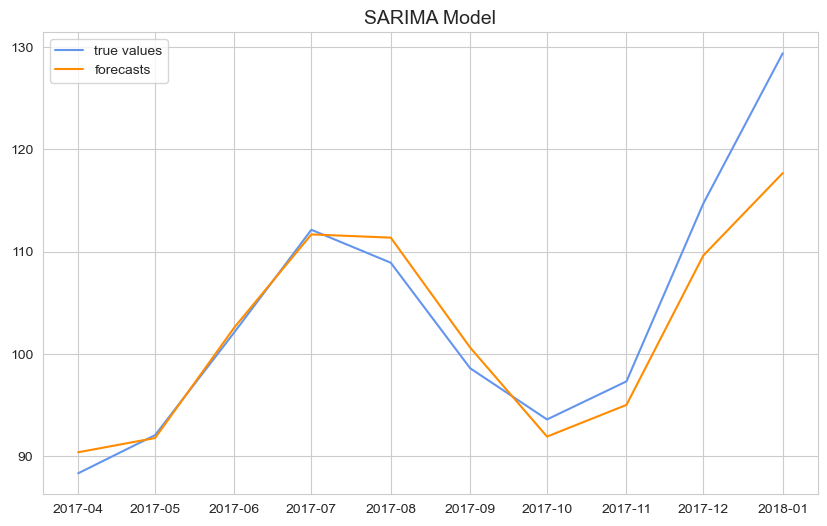

In [48]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("SARIMA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

In [49]:
sarima3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               value   No. Observations:                  387
Model:             SARIMAX(0, 1, 1)x(3, 0, [], 12)   Log Likelihood                 817.688
Date:                             Tue, 15 Aug 2023   AIC                          -1625.376
Time:                                     20:25:39   BIC                          -1605.597
Sample:                                 01-01-1985   HQIC                         -1617.532
                                      - 03-01-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4245      0.045     -9.476      0.000      -0.512      -0.337
ar.S.L12       0.4801      0.049      9.759      0.000       0.384       0.577
ar.S.L24       0.1321      0.057      2.317      0.020       0.020       0.244
ar.S.L36       0.3645      0.053      6.888      0.000       0.261       0.468
sigma2         0.0008   5.47e-05     14.130      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   5.11   Jarque-Bera (JB):                 0.46
Prob(Q):                              0.02   Prob(JB):                         0.79
Heteroskedasticity (H):               1.77   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Residual Diagnostics

## Final Model 1

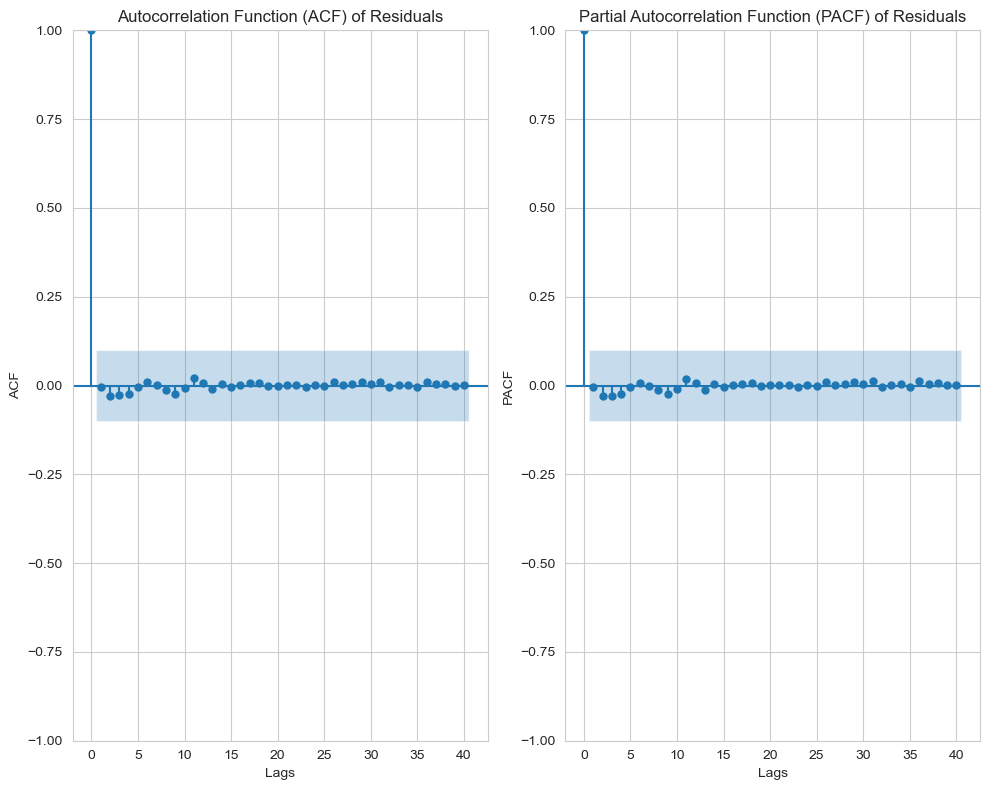

In [83]:
# Create a figure and axis
fig, axes = plt.subplots(1, 2)

# Plot ACF with confidence bands
plot_acf(sarima2.resid, lags=40, alpha=0.05, ax=axes[0])
axes[0].set_xlabel("Lags")
axes[0].set_ylabel("ACF")
axes[0].set_title("Autocorrelation Function (ACF) of Residuals")

# Plot PACF with confidence bands
plot_pacf(sarima2.resid, lags=40, alpha=0.05, ax=axes[1])
axes[1].set_xlabel("Lags")
axes[1].set_ylabel("PACF")
axes[1].set_title("Partial Autocorrelation Function (PACF) of Residuals")

# Adjust layout
plt.tight_layout()
plt.show()

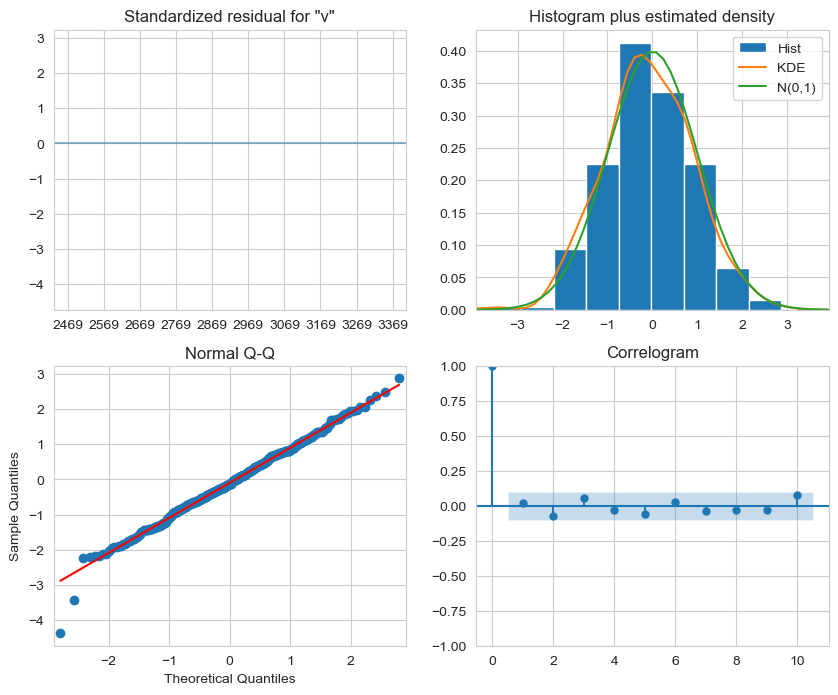

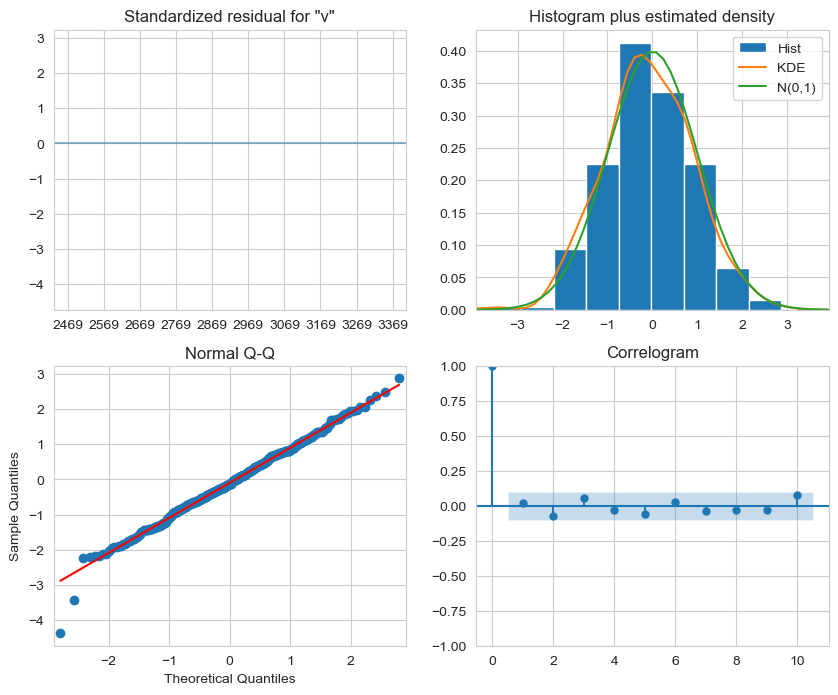

In [56]:
sarima2.plot_diagnostics()

## Final Model 2

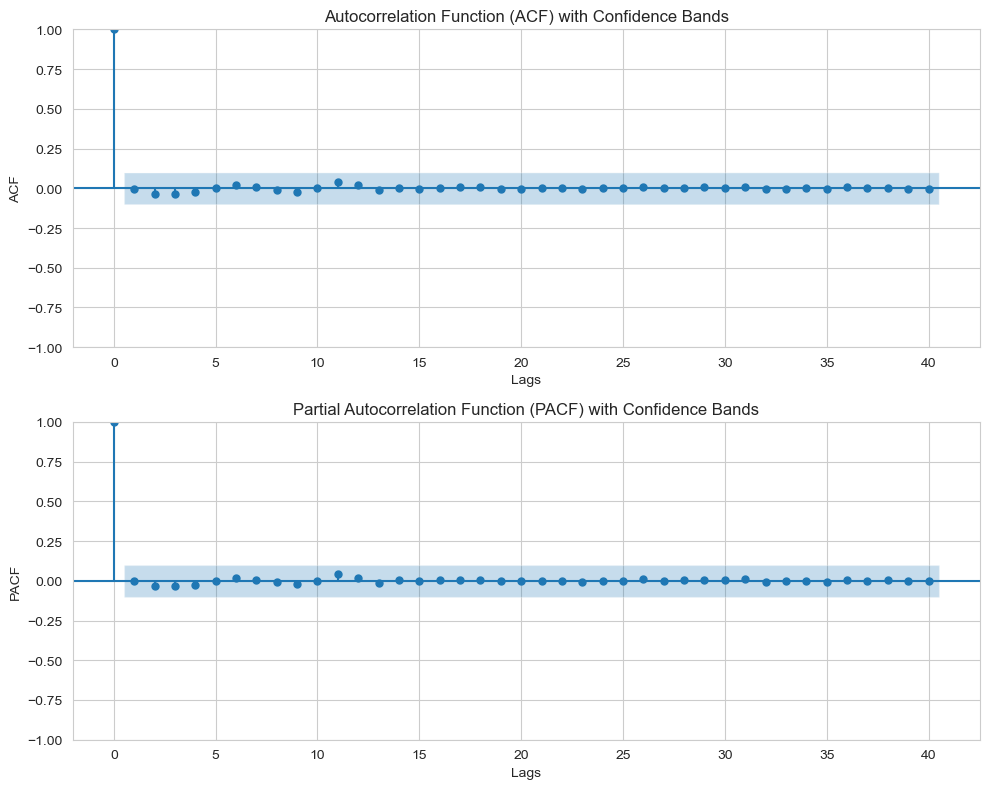

In [57]:
# Create a figure and axis
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot ACF with confidence bands
plot_acf(sarima3.resid, lags=40, alpha=0.05, ax=axes[0])
axes[0].set_xlabel("Lags")
axes[0].set_ylabel("ACF")
axes[0].set_title("Autocorrelation Function (ACF) with Confidence Bands")

# Plot PACF with confidence bands
plot_pacf(sarima3.resid, lags=40, alpha=0.05, ax=axes[1])
axes[1].set_xlabel("Lags")
axes[1].set_ylabel("PACF")
axes[1].set_title("Partial Autocorrelation Function (PACF) with Confidence Bands")

# Adjust layout
plt.tight_layout()
plt.show()

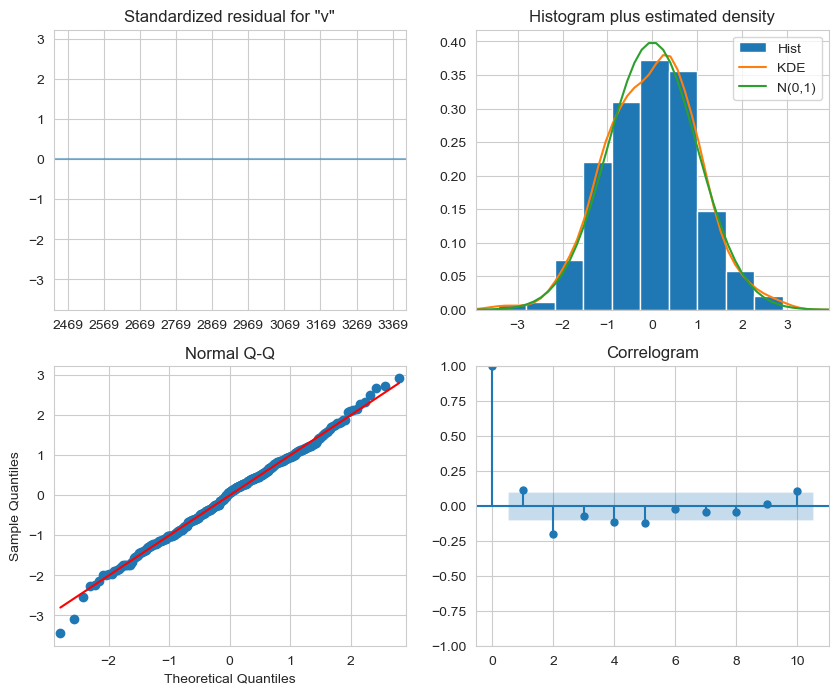

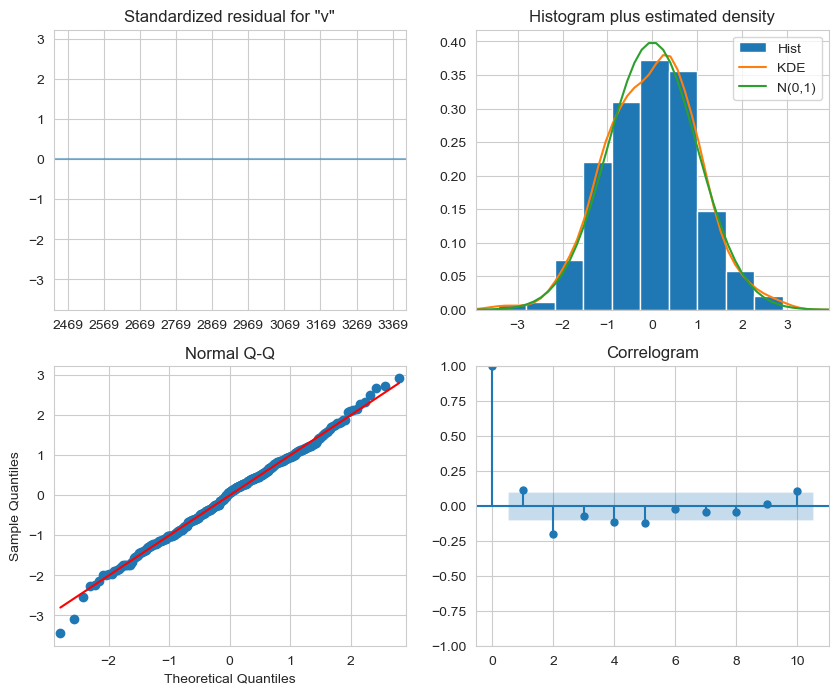

In [58]:
sarima3.plot_diagnostics()